<a href="https://colab.research.google.com/github/MichaelBMS/keras/blob/master/tri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import display
import os
%matplotlib inline

In [2]:
# Paths for loading/storing results.
name = 'results/Gaussian_MINEE' # filename
chkpt_name = name+'.pt'              # checkpoint
fig_name = name+'.pdf'               # output figure

# use GPU if available
if torch.cuda.is_available(): 
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

# initialize random seed
np.random.seed(0)
torch.manual_seed(0);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


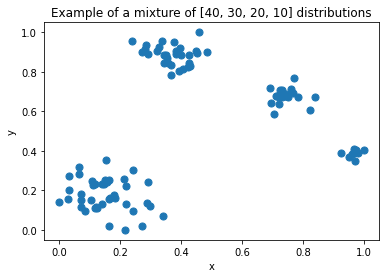

In [3]:
sample_size = 100   # sample size
n_components = [40, 30, 20, 10]
sample_size_v = 50   # validation size
n_components_v = [20, 15, 10, 5] 


center = [[0.1, 0.1], [0.3, 0.8], [0.6, 0.6], [0.8, 0.3]]

rep = 1             # number of repeated runs
d = 2               # number of dimensions for X (and Y)

X = np.zeros((rep,sample_size,d))
Validation = np.zeros((rep,sample_size_v,d))


from sklearn.datasets.samples_generator import make_blobs
from mpl_toolkits.mplot3d import Axes3D
X[0, :, :], truth1 = make_blobs(n_samples=n_components, centers=center, 
                      cluster_std = [0.08, 0.06, 0.04, 0.02], 
                      random_state=1)
Validation[0, :, :], truth2 = make_blobs(n_samples=n_components_v, centers=center, 
                      cluster_std = [0.08, 0.06, 0.04, 0.02], 
                      random_state=2)
def Normalize(X):
    x = X[0, :, 0]
    y = X[0, :, 1]# Define the borders
    deltaX = max(x) - min(x)
    deltaY = max(y) - min(y)
    X[0, :, 0] = (X[0, :, 0] - min(x))/deltaX
    X[0, :, 1] = (X[0, :, 1] - min(y))/deltaY
    X = np.array(X)
    plt.scatter(X[0, :, 0], X[0, :, 1], s=50)
    plt.title(f"Example of a mixture of {n_components} distributions")
    plt.xlabel("x")
    plt.ylabel("y")
    return X

X = Normalize(X)
# Extract x and y


(1, 100, 2)


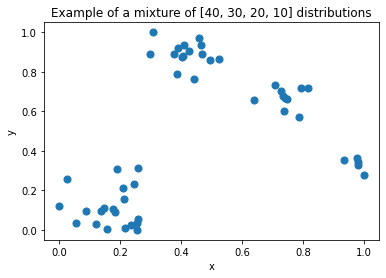

In [4]:
Validation = Normalize(Validation)
print(X.shape)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np


def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch


def _uniform_sample(data, batch_size):
    # Sample the reference uniform distribution
    data_min = data.min(dim=0)[0]
    data_max = data.max(dim=0)[0]
    return (data_max - data_min) * torch.rand((batch_size, data_min.shape[0])) + data_min


def _div(net, data, ref):
    # Calculate the divergence estimate using a neural network
    mean_f = net(data).mean()
    log_mean_ef_ref = torch.logsumexp(net(ref), 0) - np.log(ref.shape[0])
    return mean_f - log_mean_ef_ref

def _prob(net, data):
    return net(data)


class MINEE():
    r"""Class for Mutual Information Neural Entropic Estimation. 

    The mutual information is estimated using neural estimation of divergences 
    to uniform reference distribution.

    Arguments:
    X (tensor): samples of X
        dim 0: different samples
        dim 1: different components
    Y (tensor): samples of Y
        dim 0: different samples
        dim 1: different components
    ref_batch_factor (float, optional): multiplicative factor to increase 
        reference sample size relative to sample size
    lr (float, optional): learning rate
    hidden_size (int, optional): size of the hidden layers
    """
    class Net(nn.Module):
        # Inner class that defines the neural network architecture
        def __init__(self, input_size=2, hidden_size=10, sigma=0.02):
            super().__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, 1)
            nn.init.normal_(self.fc1.weight, std=sigma)
            nn.init.constant_(self.fc1.bias, 0)
            nn.init.normal_(self.fc2.weight, std=sigma)
            nn.init.constant_(self.fc2.bias, 0)
            nn.init.normal_(self.fc3.weight, std=sigma)
            nn.init.constant_(self.fc3.bias, 0)

        def forward(self, input):
            output = F.elu(self.fc1(input))
            output = F.elu(self.fc2(output))
            output = self.fc3(output)
            return output

    def __init__(self, X, batch_size=32, ref_batch_factor=1, lr=5e-2, hidden_size=10):
        self.lr = lr
        self.batch_size = batch_size
        self.ref_batch_factor = ref_batch_factor
        self.X = X

        self.X_ref = _uniform_sample(X, batch_size=int(
            self.ref_batch_factor * X.shape[0]))
        self.X_net = MINEE.Net(input_size=X.shape[1], hidden_size=100)
        self.X_optimizer = optim.Adam(self.X_net.parameters(), lr=lr)

    def step(self, iter=1):
        r"""Train the neural networks for one or more steps.

        Argument:
        iter (int, optional): number of steps to train.
        """
        for i in range(iter):
            self.X_optimizer.zero_grad()
            batch_X = _resample(self.X, batch_size=self.batch_size)
            batch_X_ref = _uniform_sample(self.X, batch_size=int(
                self.ref_batch_factor * self.batch_size))

           
            batch_loss_X = -_div(self.X_net, batch_X, batch_X_ref)
            batch_loss_X.backward()
            self.X_optimizer.step()
            
    def prob(self):
        return _prob(self.X_net, A)
        
       
    def forward(self, X=None):
        r"""Evaluate the neural networks to return an array of 3 divergences estimates 
        (dXY, dX, dY).

        Outputs:
            dXY: divergence of sample joint distribution of (X,Y) 
                to the uniform reference
            dX: divergence of sample marginal distribution of X 
                to the uniform reference
            dY: divergence of sample marginal distribution of Y
                to the uniform reference

        Arguments:
            X (tensor, optional): samples of X.
            Y (tensor, optional): samples of Y.
        By default, X and Y for training is used. 
        The arguments are useful for testing/validation with a separate data set.
        """
        if X is None:
            X = self.X
            
        X_ref = _uniform_sample(X, batch_size=int(
            self.ref_batch_factor * X.shape[0]))
        
        dX = _div(self.X_net, X, X_ref).cpu().item()
        return dX

    def estimate(self, X=None):
        r"""Return the mutual information estimate.

        Arguments:
            X (tensor, optional): samples of X.
            Y (tensor, optional): samples of Y.
        By default, X and Y for training is used. 
        The arguments are useful for testing/validation with a separate data set.
        """
        dX = self.forward(X)
        return dX

    def state_dict(self):
        r"""Return a dictionary storing the state of the estimator.
        """
        return {
            
            'X_net': self.X_net.state_dict(),
            'X_optimizer': self.X_optimizer.state_dict(),
            'X': self.X,
            'lr': self.lr,
            'batch_size': self.batch_size,
            'ref_batch_factor': self.ref_batch_factor
        }

    def load_state_dict(self, state_dict):
        r"""Load the dictionary of state state_dict.
        """
        
        self.X_net.load_state_dict(state_dict['X_net'])
        self.X_optimizer.load_state_dict(state_dict['X_optimizer'])
        
        self.X = state_dict['X']
        if 'lr' in state_dict:
            self.lr = state_dict['lr']
        if 'batch_size' in state_dict:
            self.batch_size = state_dict['batch_size']
        if 'ref_batch_factor' in state_dict:
            self.ref_batch_factor = state_dict['ref_batch_factor']

In [6]:
batch_size = 100        # batch size of data sample
ref_batch_factor = 10  # batch size expansion factor for reference sample
lr = 1e-2               # learning rate

minee_list = []

for i in range(rep):
    minee_list.append(MINEE(torch.Tensor(X[i]),
                            batch_size=batch_size,ref_batch_factor=ref_batch_factor,lr=lr))
dX_list = np.zeros((rep,0))
dV_list = []

def evaluate_prob(model):
    grid = 100
    a = np.zeros((1, grid*grid, 2))
    for i in range(grid):
        for j in range(grid):
            a[0, i*grid+j, 0] = i/grid 
            a[0, i*grid+j, 1] = j/grid
    b = torch.exp(model.X_net((torch.Tensor(a))))
    c = b.cpu().detach().numpy()
    return a, c

def validate(model, validation):
    b = torch.exp(model.X_net((torch.Tensor(validation))))
    c = b.cpu().detach().numpy()
    return c

In [7]:
load_available = True # set to False to prevent loading previous results
if load_available and os.path.exists(chkpt_name):
    checkpoint = torch.load(
        chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
    dX_list = checkpoint['dX_list']
    minee_state_list = checkpoint['minee_state_list']
    for i in range(rep):
        minee_list[i].load_state_dict(minee_state_list[i])
    print('Previous results loaded.')

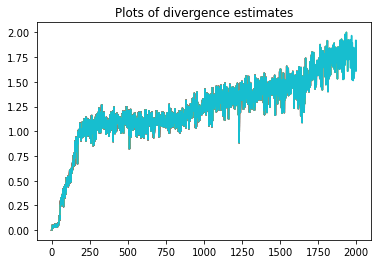

In [8]:
continue_train = True  # set to True to continue to train
num_big_steps = 40    # number of small steps
num_small_steps = 50  # number of big steps
if continue_train:
    for k in range(num_big_steps):
        for j in range(num_small_steps):
            dX_list = np.append(dX_list, np.zeros((rep, 1)), axis=1)
            for i in range(rep):
                minee_list[i].step()
                dX_list[i, -1] = minee_list[i].forward()
                dV_list.append(minee_list[i].estimate(X=(torch.Tensor(Validation[0]))))

        # To show intermediate works
        for i in range(rep):
            plt.plot(dX_list[i, :],label='dX')
            plt.title('Plots of divergence estimates')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    display.clear_output()

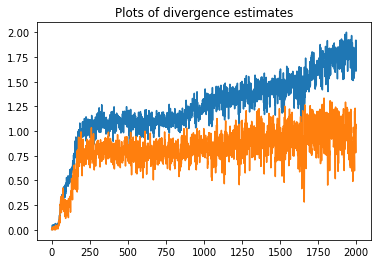

In [9]:
for i in range(rep):
    plt.plot(dX_list[i, :],label='dX')
    plt.plot(dV_list[:],label='dV')
    plt.title('Plots of divergence estimates')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    display.clear_output()

[[0.   0.  ]
 [0.   0.01]
 [0.   0.02]
 ...
 [0.99 0.97]
 [0.99 0.98]
 [0.99 0.99]]
[0.00401843 0.01057522 0.03764939 ... 0.06990825 0.05464521 0.04273192]


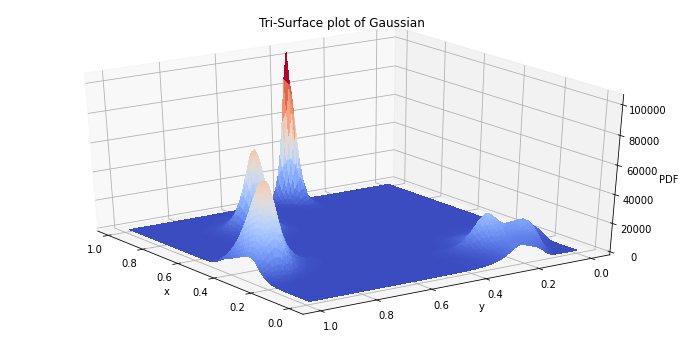

In [10]:
input, output = evaluate_prob(minee_list[0])
print(input[0, :, :])
print(output[0, :, 0])
A = input[0, :, 0]
B = input[0, :, 1]
Z = output[0, :, 0]
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(A, B, Z, linewidth=0, cmap='coolwarm', antialiased=False)
#w = ax.plot_wireframe(input[0, :, 0], input[0, :, 1], output[0, :, 0])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Tri-Surface plot of Gaussian')
ax.view_init(30, 145);
